# import libraries

In [1]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter
import time
from scipy import ndimage
from scipy.stats import chi2
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
from utilFuncs import *
import mdspy as lp
import imp
imp.reload(lp)

#--- 
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

# Parameters

In [4]:
#--- to be modified by users

#
NeighList = True
#
Ovitos = True #--- don't change!
#
nevery = 1 #--- proc. every n times
#
ml = True; ReadDisc = False; WritDisc = True
#

#--- input directory
path = '../examples/neighlist'

#--- input file (lammps dump file)
fileName = '%s/lmp.dump'%path



## Dump File

In [3]:
#--- parse lammps dump files 
print('parsing %s'%fileName)
t0 = time.time()
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, 
#                 columns = {'c_mystress[4]':'sxy'},
                )
print('duration=%s s'%(time.time()-t0))

parsing ../examples/neighlist/lmp.dump
duration=1.4876530170440674 s


In [5]:
#--- timesteps
lmpData.coord_atoms_broken.keys()

dict_keys([0, 10000])

# Neighbor list

In [ ]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass

    #--- set the cut-off distance
    cutoff=5.0
    
    #--- build neighbor list
    !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff
    
    #--- parse
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)
    !rm neighList.xyz    


rm: neighList.xyz: No such file or directory
InputFile= ../examples/neighlist/lmp.dump
num_frames= 2
frame=0
frame=1


In [ ]:
itime = 10000
lmpNeigh.coord_atoms_broken[itime].head()

# Machine learning

* NeighList = True #--- build neighbor list 


## Descriptors

In [28]:
def GetAttribute(df,rbar,sigma):
    sigma2=sigma*sigma
    rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
    #---
    tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
    tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
    return np.array(tmp_sum)


if ml:
    
    #--- structure function
    if not ReadDisc:
        df = lmpNeigh.coord_atoms_broken[itime] #--- ref. state!!

        #--- radial dunction: eq 1. in Marinica et al. 
        
        #--- set parameters
        rpeak = 2.5 #--- r associated with the 1st peak in g(r)
        sigma=0.05*rpeak #--- annulus thickness
        
        #--- annulus radii
        rbars = np.arange(0.6*rpeak,cutoff,sigma)
        #
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)

#         #--- angular term
#         cutoffAng = 4.5 #--- 2nd peak
        
#         #--- filter df: decrease cutoff distance for the anglular analysis
#         df_filtrd = df[df['DIST']<cutoffAng]
#         df_filtrd.reset_index(drop=True,inplace=True)
        
#         #---
#         t0=time.time()
# #         pdb.set_trace()
#         angst = lp.AngularStruct(df_filtrd)
#         angst.GetDistAngle()
#         print('assemble triplets t=%s s'%(time.time()-t0))
#         #--- set params. list
#         deltas = np.arange(0.6*rpeak,cutoffAng,3.0*sigma)
#         b=np.array([1.0,-1.0])
#         c=np.array([0.5,1.0,2.0])
#         #
#         xx, yy, zz = np.meshgrid(deltas,b,c)
#         plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
#         print('num(ang. features)=%s'%(len(plist)))
#         #
#         t0=time.time()    
#         structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
#         print('apply parameters t=%s s'%(time.time()-t0))
#         print('structFuncAng.shape=',structFuncAng.shape)


num(radial features)=28
radial struct t=1374.1252117156982 s
structFuncRad.shape= (50688, 28)


### Plot

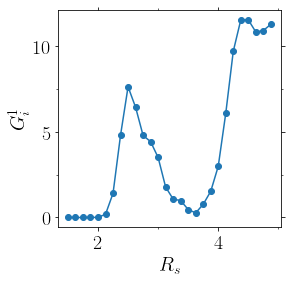

<AxesSubplot:xlabel='$R_s$', ylabel='$G^1_i$'>

In [29]:
PltErr(rbars,structFuncRad[0,0:len(rbars)],
       yerr=None,
       xstr=r'$R_s$',
       ystr=r'$G^1_i$',
       title='%s/G1i.png'%path,
      )